In [93]:
import numpy as np
import matplotlib.pyplot as plt
from formatting_data import get_data_frame, normalise
from numba import njit
from functions import reverse_normaliser
import textwrap
import math
import pandas as pd

In [88]:
df, game_df = get_data_frame(10000) #game_df used for identifying game using game_id
df.head(3)

,user_id,game_id,playtime
0,0,11,468.0
1,0,21,3358.0
2,0,97,6009.0


In [49]:
user0 = df.loc[df.user_id == 1].sort_values(by='playtime', ascending=False).head(10)[['game_id', 'playtime']]
user0_games = game_df.set_index(game_df.game_id).loc[user0.game_id, 'game_name']
playtimes = user0.playtime

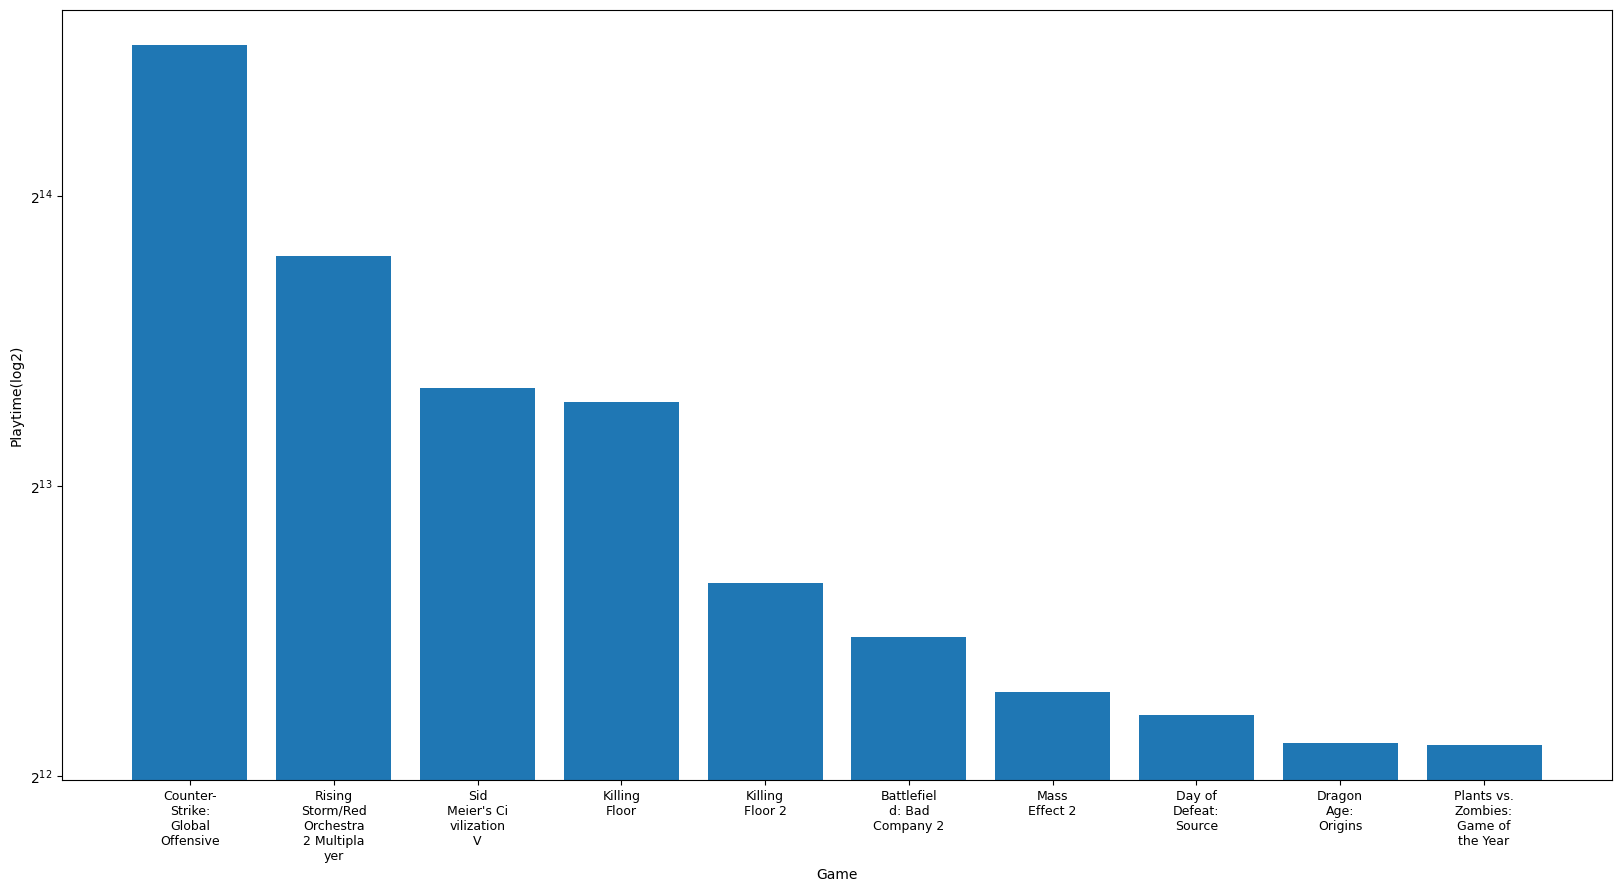

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar([textwrap.fill(label, 10) for label in user0_games[0:20]], playtimes[0:20])
ax.set_xlabel('Game')
ax.set_ylabel('Playtime(log2)')
ax.set_yscale('log', base=2)
ax.tick_params(axis='x', labelsize=9)
plt.show()

In [11]:
#creating utility matrix
utility_matrix = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [12]:
R = (utility_matrix != 0).astype(int)
played = utility_matrix != 0

In [13]:
num_features = 20

np.random.seed(9)

#initialising users and items features randomly
user_matrix = np.random.uniform(0,1,(utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(0,1,(utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

In [14]:
def cost(y, pred, R, chunk_size=500, _lambda=1.0, alpha=61.0):
    cost = (np.sum(user_matrix ** 2) + np.sum(item_matrix ** 2)) * _lambda #regularisation
    
    for i in range(0, y.shape[0], chunk_size):
        cost += np.sum(
                np.square(
                np.subtract(y[i:i+chunk_size], pred[i:i+chunk_size] * R[i:i+chunk_size])
            )
        )

    return cost/2
           

In [15]:
pred = user_matrix @ item_matrix.T
cost(utility_matrix, pred, R)

291907967669.9852

In [16]:
alpha = 0.0000001
lambda_ = 0.1

In [24]:
count = 0
for i in range(10000):
    count+=1

    pred = user_matrix @ item_matrix.T
    error = (utility_matrix - pred * R)

    item_slope = error.T @ user_matrix
    item_slope *= alpha

    user_slope = error @ item_matrix
    user_slope *= alpha

    user_matrix += user_slope
    item_matrix += item_slope

    pred = user_matrix @ item_matrix.T
    if(count % 500 == 0):
        print(count, cost(utility_matrix, pred, R))

500 4549107.765037599
1000 4508939.3476863615
1500 4470758.639365819
2000 4434447.654580744
2500 4399915.120294818
3000 4367039.903123839
3500 4335736.659332802
4000 4305903.897724791
4500 4277475.647526378
5000 4250364.104908241


KeyboardInterrupt: 

In [89]:
top20 = np.sort(pred[1])[-20:]
top20i = np.where(np.isin(pred[1], top20))

In [91]:
top20i

(array([  23,   26,  173,  371,  372,  452,  597,  709,  753,  763,  797,
         894,  991, 1119, 1133, 1387, 1588, 2136, 2146, 2309], dtype=int64),)

In [95]:
pred[1,23]

23532.406

In [125]:
time_df = pd.DataFrame({'game_id': np.array(top20i).flatten(), 'predicted_playtime': pred[1,top20i].flatten()})
top20_df = pd.merge(game_df.iloc[top20i], time_df, on=['game_id'])
top20_df = top20_df.sort_values(ascending=False, by=['predicted_playtime'])
top20_df = top20_df.reset_index(drop=True)
top20_df

,game_id,game_name,predicted_playtime
0,23,Counter-Strike: Global Offensive,23532.406250
1,1119,Warframe,17577.609375
2,2146,AdVenture Capitalist,15096.469727
3,452,Rising Storm/Red Orchestra 2 Multiplayer,14193.476562
4,1387,Rust,12496.009766
5,797,America's Army: Proving Grounds,11478.765625
6,2309,Clicker Heroes,11260.585938
7,173,Sid Meier's Civilization V,10341.415039
8,26,Killing Floor,10018.861328
9,753,APB Reloaded,9467.555664


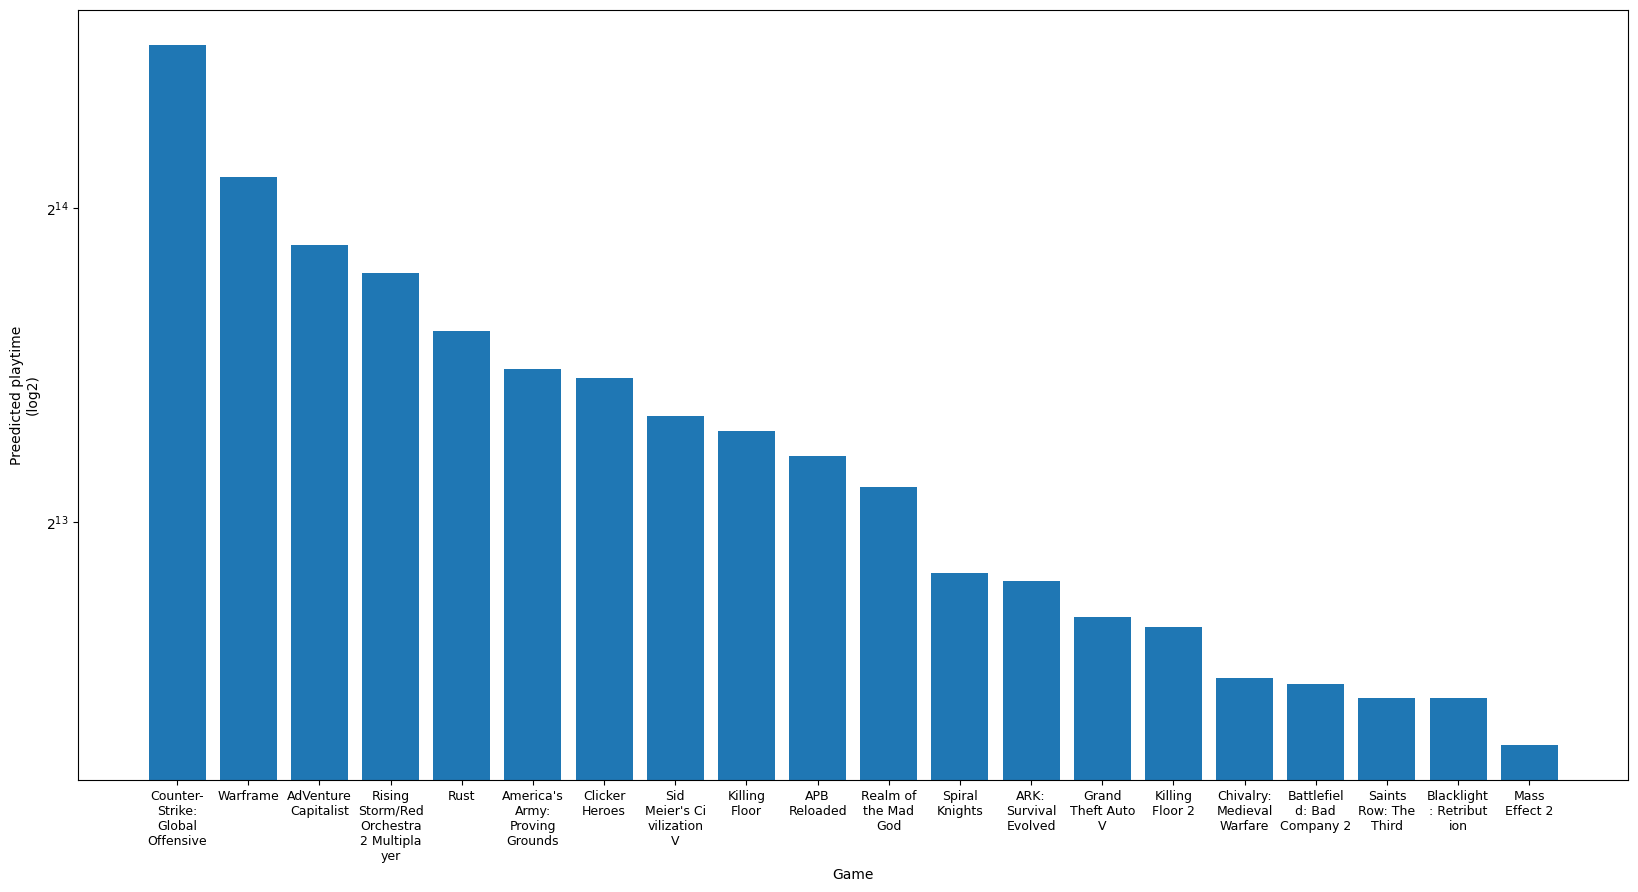

In [127]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar([textwrap.fill(label, 10) for label in top20_df.game_name], top20_df.predicted_playtime)
ax.set_xlabel('Game')
ax.set_ylabel('Preedicted playtime\n(log2)')
ax.set_yscale('log', base=2)
ax.tick_params(axis='x', labelsize=9)
plt.show()